# Introduction to Neural Networks

The data set contains the following features for different species of iris flowers:

- `sepal_length` - Continuous variable measured in centimeters.
- `sepal_width` - Continuous variable measured in centimeters.
- `petal_length` - Continuous variable measured in centimeters.
- `petal_width` - Continuous variable measured in centimeters.
- `species` - Categorical. 2 species of iris flowers, Iris-virginica or Iris-versicolor.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

### Exploring and Visualizing the Data

In [2]:
iris = pd.read_csv("iris.csv")

In [3]:
iris.shape

(100, 5)

In [4]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,7.0,3.2,4.7,1.4,Iris-versicolor
1,6.4,3.2,4.5,1.5,Iris-versicolor
2,6.9,3.1,4.9,1.5,Iris-versicolor
3,5.5,2.3,4.0,1.3,Iris-versicolor
4,6.5,2.8,4.6,1.5,Iris-versicolor


In [5]:
# shuffling the rows

shuffled_rows = np.random.permutation(iris.index)
iris = iris.loc[shuffled_rows,:]
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
84,6.1,2.6,5.6,1.4,Iris-virginica
68,7.7,2.6,6.9,2.3,Iris-virginica
11,5.9,3.0,4.2,1.5,Iris-versicolor
53,6.3,2.9,5.6,1.8,Iris-virginica
13,6.1,2.9,4.7,1.4,Iris-versicolor


In [6]:
iris.species.unique()

array(['Iris-virginica', 'Iris-versicolor'], dtype=object)

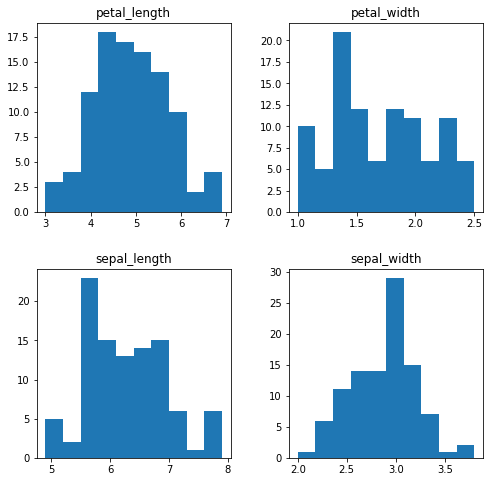

In [7]:
iris.hist(figsize=(8,8), grid= False)
plt.show()

### Representing the logistic Regression function as a neuron

In [8]:
# Variables to test sigmoid_activation
iris["ones"] = np.ones(iris.shape[0])
X = iris[['ones', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y = (iris.species == 'Iris-versicolor').values.astype(int)

# The first observation
x0 = X[0]

# Initialize thetas randomly 
theta_init = np.random.normal(0,0.01,size=(5,1))

def sigmoid_activation(x, theta):
    x = np.asarray(x)
    theta = np.asarray(theta)
    return 1 / (1 + np.exp(-np.dot(theta.T, x)))
                
a1 = sigmoid_activation(x0, theta_init)
a1

array([ 0.50562436])

### Computing the cost from just a single observation

In [9]:
x0 = X[0]
y0 = y[0]

theta_init = np.random.normal(0,0.01,size=(5,1))

def singlecost(X, y, theta):
    h = sigmoid_activation(X.T, theta)
    cost = -np.mean(y * np.log(h) + (1-y) * np.log(1-h))
    return cost

In [10]:
first_cost = singlecost(x0, y0, theta_init)
first_cost

0.65053646186537539

### Computing the average gradients

In [11]:
theta_init = np.random.normal(0,0.01,size=(5,1))

grads = np.zeros(theta_init.shape)

n = X.shape[0]

for j, obs in enumerate(X):
    h = sigmoid_activation(obs, theta_init)
    delta = (y[j]-h) * h * (1-h) * obs
    grads += delta[:,np.newaxis] / X.shape[0]

### Learning a two layer network

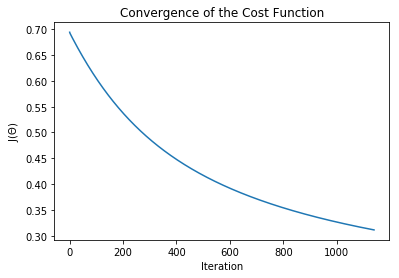

In [12]:
theta_init = np.random.normal(0,0.01,size=(5,1))

# set a learning rate
learning_rate = 0.1
# maximum number of iterations for gradient descent
maxepochs = 10000       
# costs convergence threshold, ie. (prevcost - cost) > convergence_thres
convergence_thres = 0.0001  

def learn(X, y, theta, learning_rate, maxepochs, convergence_thres):
    costs = []
    cost = singlecost(X, y, theta)  # compute initial cost
    costprev = cost + convergence_thres + 0.01  # set an inital costprev to past while loop
    counter = 0  # add a counter
    # Loop through until convergence
    for counter in range(maxepochs):
        grads = np.zeros(theta.shape)
        for j, obs in enumerate(X):
            h = sigmoid_activation(obs, theta)   # Compute activation
            delta = (y[j]-h) * h * (1-h) * obs   # Get delta
            grads += delta[:,np.newaxis]/X.shape[0]  # accumulate
        
        # update parameters 
        theta += grads * learning_rate
        costprev = cost  # store prev cost
        cost = singlecost(X, y, theta) # compute new cost
        costs.append(cost)
        if np.abs(costprev-cost) < convergence_thres:
            break
        
    plt.plot(costs)
    plt.title("Convergence of the Cost Function")
    plt.ylabel("J($\Theta$)")
    plt.xlabel("Iteration")
    plt.show()
    return theta
        
theta = learn(X, y, theta_init, learning_rate, maxepochs, convergence_thres)

### Building a Feedforward Neural Network

In [13]:
theta0_init = np.random.normal(0,0.01,size=(5,4))
theta1_init = np.random.normal(0,0.01,size=(5,1))

def feedforward(X, theta0, theta1):
    a1 = sigmoid_activation(X.T, theta0).T
    a1 = np.column_stack([np.ones(a1.shape[0]), a1])
    out = sigmoid_activation(a1.T, theta1)
    return out

h = feedforward(X, theta0_init, theta1_init)

### Multiple Neural Network Cost Function

In [14]:
def multiplecost(X, y, theta0, theta1):
    h = feedforward(X, theta0, theta1) 
    error = y * np.log(h) + (1-y) * np.log(1-h)
    return -np.mean(error)

In [15]:
theta0_init = np.random.normal(0,0.01,size=(5,4))
theta1_init = np.random.normal(0,0.01,size=(5,1))
c = multiplecost(X, y, theta0_init, theta1_init)
c

0.69313894550513988

### Implementing Backpropagation

In [16]:
class NNet3:
    def __init__(self, learning_rate=0.5, maxepochs=1e4, convergence_thres=1e-5, hidden_layer=4):
        self.learning_rate = learning_rate
        self.maxepochs = int(maxepochs)
        self.convergence_thres = 1e-5
        self.hidden_layer = int(hidden_layer)
        
    def _multiplecost(self, X, y):
        # feed through network
        l1, l2 = self._feedforward(X) 
        # compute error
        inner = y * np.log(l2) + (1-y) * np.log(1-l2)
        # negative of average error
        return -np.mean(inner)
    
    def _feedforward(self, X):
        # feedforward to the first layer
        l1 = sigmoid_activation(X.T, self.theta0).T
        # add a column of ones for bias term
        l1 = np.column_stack([np.ones(l1.shape[0]), l1])
        # activation units are then inputted to the output layer
        l2 = sigmoid_activation(l1.T, self.theta1)
        return l1, l2
    
    def predict(self, X):
        _, y = self._feedforward(X)
        return y
    
    def learn(self, X, y):
        nobs, ncols = X.shape
        self.theta0 = np.random.normal(0,0.01,size=(ncols,self.hidden_layer))
        self.theta1 = np.random.normal(0,0.01,size=(self.hidden_layer+1,1))
        
        self.costs = []
        cost = self._multiplecost(X, y)
        self.costs.append(cost)
        costprev = cost + self.convergence_thres+1  # set an inital costprev to past while loop
        counter = 0  # intialize a counter

        # Loop through until convergence
        for counter in range(self.maxepochs):
            # feedforward through network
            l1, l2 = self._feedforward(X)

            # Start Backpropagation
            # Compute gradients
            l2_delta = (y-l2) * l2 * (1-l2)
            l1_delta = l2_delta.T.dot(self.theta1.T) * l1 * (1-l1)

            # Update parameters by averaging gradients and multiplying by the learning rate
            self.theta1 += l1.T.dot(l2_delta.T) / nobs * self.learning_rate
            self.theta0 += X.T.dot(l1_delta)[:,1:] / nobs * self.learning_rate
            
            # Store costs and check for convergence
            counter += 1  # Count
            costprev = cost  # Store prev cost
            cost = self._multiplecost(X, y)  # get next cost
            self.costs.append(cost)
            if np.abs(costprev-cost) < self.convergence_thres and counter > 500:
                break

### Initializing and Training the model

In [17]:
learning_rate = 0.5
maxepochs = 10000    
convergence_thres = 0.00001  
hidden_units = 4

model = NNet3(learning_rate=learning_rate, maxepochs=maxepochs, convergence_thres=convergence_thres, hidden_layer=hidden_units)

model.learn(X, y)

### Plotting the costs

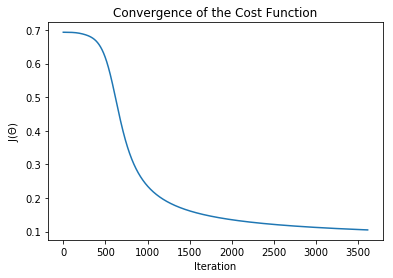

In [18]:
plt.plot(model.costs)
plt.title("Convergence of the Cost Function")
plt.ylabel("J($\Theta$)")
plt.xlabel("Iteration")
plt.show()

### Splitting the Data

In [19]:
X_train = X[:70]
y_train = y[:70]

X_test = X[-30:]
y_test = y[-30:]

### Predicting the species of iris flowers

In [20]:
learning_rate = 0.5
maxepochs = 10000       
convergence_thres = 0.00001  
hidden_units = 4

model = NNet3(learning_rate=learning_rate, maxepochs=maxepochs, convergence_thres=convergence_thres, hidden_layer=hidden_units)
model.learn(X_train, y_train)
yhat = model.predict(X_test)[0]

In [21]:
auc = roc_auc_score(y_test, yhat)
auc

1.0